In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from d2l import torch as d2l
import CustomImageDataset as CID
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

### 1. Explore the dataset. Understand the label distributions and data size.

In [3]:
# Load the dataset
train_dataset = CID.CustomImageDataset(annotations_file='./images/train.csv', img_dir='./images/train/')
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Load the test set
val_dataset = CID.CustomImageDataset(annotations_file='./images/test.csv', img_dir='./images/test/')
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)

In [4]:
# Load the dataset
#train_dataset = CID.CustomImageDataset(annotations_file='./images/train.csv', img_dir='./images/train/')

# Split the dataset into train and test
#train_indices, test_indices = train_test_split(range(len(train_dataset)), test_size=0.33, random_state=42)

# Create train and test subsets
#train_subset = torch.utils.data.Subset(train_dataset, train_indices)
#val_subset = torch.utils.data.Subset(train_dataset, test_indices)

# Create data loaders
#train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
#val_loader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=True)

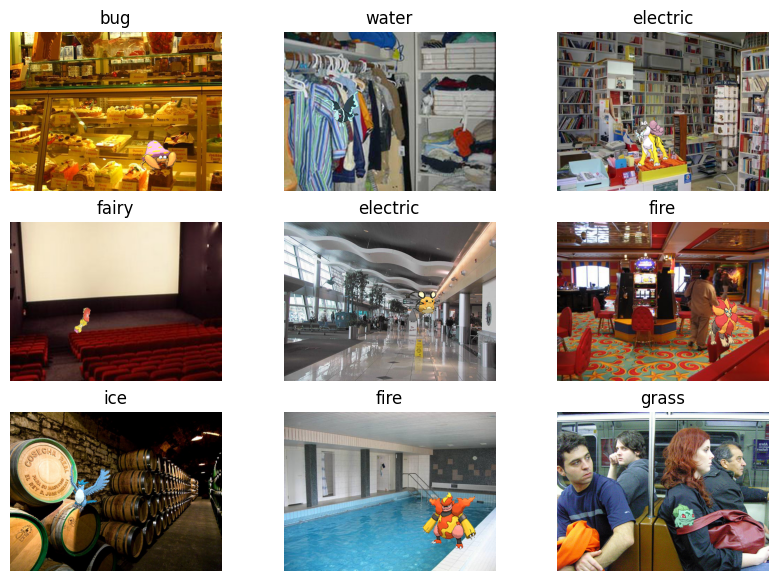

In [80]:
train_dataset.show_batch(batch_size=10)

In [125]:
# Display image and label.
# Check shape and overall info of train dataset
print("Train dataset:")
print("Number of samples:", len(train_dataset))
print("Shape of the first sample image tensor:", train_dataset[0][0].shape)  
print("Label of the first sample:", train_dataset[3][1])  

# Check shape and overall info of validation dataset
print("\nValidation dataset:")
print("Number of samples:", len(val_dataset))
print("Shape of the first sample image tensor:", val_dataset[0][0].shape)  
print("Label of the first sample:", val_dataset[3][1]) 

Train dataset:
Number of samples: 6440
Shape of the first sample image tensor: torch.Size([3, 300, 400])
Label of the first sample: 4

Validation dataset:
Number of samples: 1650
Shape of the first sample image tensor: torch.Size([3, 300, 400])
Label of the first sample: 0


### 2. Create an MLP architecture to learn the main type of Pokemon in each image (Multiclass classification). Train the model and evaluate it. Explain how you discovered the best architecture and what regularization, optimizers, etc you used.

In [5]:
# MLP architecture
class PokemonMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, dropout_prob):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(), 
            nn.LazyLinear(num_hiddens),
            nn.ReLU(), 
            nn.Dropout(dropout_prob),
            nn.LazyLinear(num_outputs))
        
    def forward(self, x):
        return self.net(x)

In [6]:
# Initialize your model
model = PokemonMLP(num_outputs= 18, num_hiddens= 256, dropout_prob = 0.2)

C:\Users\Utilizador\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [85]:
# Training loop
for epoch in range(4):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader, 0):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print progress
        running_loss += loss.item()
        if i % 10 == 9:  # Print every 10 batches
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 10:.4f}")
            running_loss = 0.0

[Epoch 1, Batch 10] Loss: 61240.7083
[Epoch 1, Batch 20] Loss: 22109.4161
[Epoch 1, Batch 30] Loss: 417.0918
[Epoch 1, Batch 40] Loss: 2.8888
[Epoch 1, Batch 50] Loss: 179.3933
[Epoch 1, Batch 60] Loss: 2.8881
[Epoch 2, Batch 10] Loss: 2.8831
[Epoch 2, Batch 20] Loss: 2.8795
[Epoch 2, Batch 30] Loss: 2.8785
[Epoch 2, Batch 40] Loss: 2.8721
[Epoch 2, Batch 50] Loss: 2.8709
[Epoch 2, Batch 60] Loss: 2.8678
[Epoch 3, Batch 10] Loss: 2.8633
[Epoch 3, Batch 20] Loss: 2.8593
[Epoch 3, Batch 30] Loss: 2.8569
[Epoch 3, Batch 40] Loss: 2.8558
[Epoch 3, Batch 50] Loss: 2.8498
[Epoch 3, Batch 60] Loss: 2.8498
[Epoch 4, Batch 10] Loss: 2.8467
[Epoch 4, Batch 20] Loss: 2.8361
[Epoch 4, Batch 30] Loss: 2.8427
[Epoch 4, Batch 40] Loss: 2.8361
[Epoch 4, Batch 50] Loss: 2.8359
[Epoch 4, Batch 60] Loss: 2.8267


In [86]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for i, (images, labels) in enumerate(val_loader, 0):
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Validation accuracy: {accuracy:.2f}%")

Validation accuracy: 12.23%


### 3. Create a CNN architecture for the same purpose, train it, and evaluate it. Compare the MLP's performance and capacity.

In [87]:
# CNN architecture
class PokemonCNN(nn.Module):
    def __init__(self, num_classes):
        super(PokemonCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 75 * 100, 128)
        self.fc2 = nn.Linear(128, num_classes) 

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 75 * 100)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [88]:
# Initialize your model
num_classes = len(train_dataset.classes)
model = PokemonCNN(num_classes = num_classes)

In [89]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [90]:
# Training loop
for epoch in range(4):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader, 0):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print progress
        running_loss += loss.item()
        if i % 10 == 9:  # Print every 10 batches
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 10:.4f}")
            running_loss = 0.0

[Epoch 1, Batch 10] Loss: 2270.6345
[Epoch 1, Batch 20] Loss: 4.2214
[Epoch 1, Batch 30] Loss: 2.9086
[Epoch 1, Batch 40] Loss: 2.9026
[Epoch 1, Batch 50] Loss: 2.8977
[Epoch 1, Batch 60] Loss: 2.8927
[Epoch 2, Batch 10] Loss: 2.8388
[Epoch 2, Batch 20] Loss: 2.8265
[Epoch 2, Batch 30] Loss: 2.8233
[Epoch 2, Batch 40] Loss: 2.7962
[Epoch 2, Batch 50] Loss: 2.7996
[Epoch 2, Batch 60] Loss: 2.7801
[Epoch 3, Batch 10] Loss: 2.4028
[Epoch 3, Batch 20] Loss: 2.3623
[Epoch 3, Batch 30] Loss: 2.3408
[Epoch 3, Batch 40] Loss: 2.3694
[Epoch 3, Batch 50] Loss: 2.3910
[Epoch 3, Batch 60] Loss: 2.4193
[Epoch 4, Batch 10] Loss: 1.8959
[Epoch 4, Batch 20] Loss: 1.7792
[Epoch 4, Batch 30] Loss: 2.0139
[Epoch 4, Batch 40] Loss: 1.7882
[Epoch 4, Batch 50] Loss: 1.8800
[Epoch 4, Batch 60] Loss: 2.0777


In [ ]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for i, (images, labels) in enumerate(val_loader, 0):
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Validation accuracy: {accuracy:.2f}%")

### 4. Use pre-trained models for transfer learning and fine-tuning for this task.

In [126]:
# Load pre-trained ResNet18
resnet = models.resnet18(weights='DEFAULT')
# Remove the last fully connected layer (classifier)
resnet = nn.Sequential(*list(resnet.children())[:-2])

# Custom classifier for Pokémon types
num_classes = 18  
classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d((1, 1)),  
    nn.Flatten(),
    nn.Linear(512, 256),  
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes)
)

# Combine ResNet and custom classifier
model = nn.Sequential(resnet, classifier)

# Data preparation
transform = transforms.Compose([
    transforms.Resize((400, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [127]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [128]:
# Training loop
for epoch in range(4):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader, 0):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print progress
        running_loss += loss.item()
        if i % 10 == 9:  # Print every 10 batches
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 10:.4f}")
            running_loss = 0.0

[Epoch 1, Batch 10] Loss: 2.8330
[Epoch 1, Batch 20] Loss: 2.7754
[Epoch 1, Batch 30] Loss: 2.6859
[Epoch 1, Batch 40] Loss: 2.6471
[Epoch 1, Batch 50] Loss: 2.6262
[Epoch 1, Batch 60] Loss: 2.5524
[Epoch 1, Batch 70] Loss: 2.5020
[Epoch 1, Batch 80] Loss: 2.4849
[Epoch 1, Batch 90] Loss: 2.5217
[Epoch 1, Batch 100] Loss: 2.5105
[Epoch 2, Batch 10] Loss: 2.4718
[Epoch 2, Batch 20] Loss: 2.3919
[Epoch 2, Batch 30] Loss: 2.4229
[Epoch 2, Batch 40] Loss: 2.4193
[Epoch 2, Batch 50] Loss: 2.4058
[Epoch 2, Batch 60] Loss: 2.3845
[Epoch 2, Batch 70] Loss: 2.3288
[Epoch 2, Batch 80] Loss: 2.3511
[Epoch 2, Batch 90] Loss: 2.3327
[Epoch 2, Batch 100] Loss: 2.3609
[Epoch 3, Batch 10] Loss: 2.2781
[Epoch 3, Batch 20] Loss: 2.2810
[Epoch 3, Batch 30] Loss: 2.2126
[Epoch 3, Batch 40] Loss: 2.2436
[Epoch 3, Batch 50] Loss: 2.2518
[Epoch 3, Batch 60] Loss: 2.2101
[Epoch 3, Batch 70] Loss: 2.2109
[Epoch 3, Batch 80] Loss: 2.2543
[Epoch 3, Batch 90] Loss: 2.2210
[Epoch 3, Batch 100] Loss: 2.2449
[Epoch 

In [116]:
# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for i, (images, labels) in enumerate(val_loader, 0):
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Validation accuracy: {accuracy:.2f}%")

Validation accuracy: 30.20%


In [8]:
# Save the fine-tuned model
#torch.save(model.state_dict(), "pokemon_classifier.pth")

In [9]:
# Load the saved state dictionary
#model.load_state_dict(torch.load("pokemon_classifier.pth"))

# Set the model to evaluation mode
#model.eval()

In [131]:
# Evaluation
model.eval()
predicted_labels = []
with torch.no_grad():
    for i, (images, labels) in enumerate(final_val_loader, 0):
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        predicted_labels += predicted.tolist()

### 5. Try data augmentation techniques, and regularization to overcome data imbalances and model overfitting.

In [140]:
train_augs = torchvision.transforms.Compose([
     torchvision.transforms.RandomHorizontalFlip(),
     torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
     torchvision.transforms.ToTensor()])

In [141]:
# Load the dataset
train_dataset = CID.CustomImageDataset(annotations_file='./images/train.csv', img_dir='./images/train/', transform=train_augs)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Load the test set
val_dataset = CID.CustomImageDataset(annotations_file='./images/test.csv', img_dir='./images/test/', transform=test_augs)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)

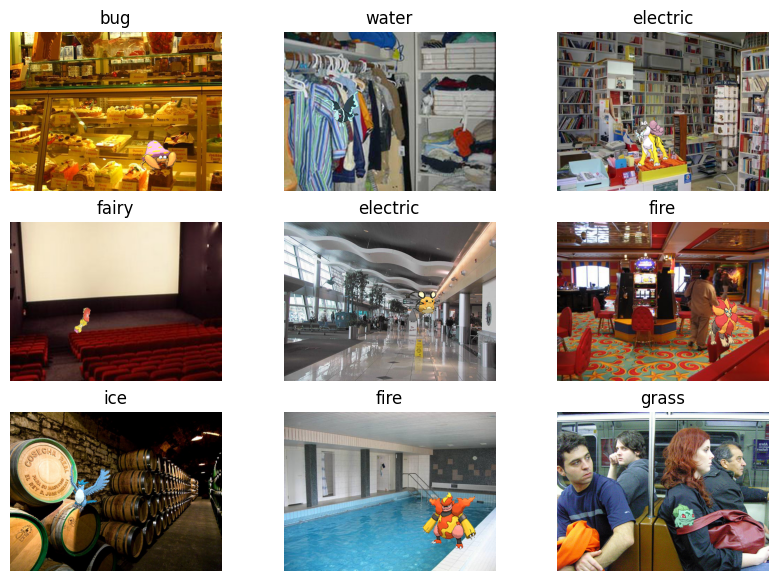

In [142]:
train_dataset.show_batch(batch_size=10)

### Submission

In [133]:
y_pred_tensor = predicted_labels

In [134]:
#save in dataframe for Kaggle submission
submission = pd.DataFrame({'Id': final_test_dataset.img_labels.iloc[:, 0], 'main_type': y_pred_tensor})
submission.to_csv('./submission.csv', index=False)